# **Clasificación de Lengua de Señas Colombiana**

---
# **Entendimiento del caso**

## **1. Contexto**

Actualmente existe una gran falta de comunicación efectiva entre personas oyentes y no oyentes que utilizan la Lengua de Señas Colombiana (LSC). Esta situación genera barreras significativas que limitan la interacción social, el acceso a servicios, educación y oportunidades laborales para las personas no oyentes. La dependencia de intérpretes, que no siempre están disponibles, agrava esta problemática, aumentando la frustración y el aislamiento social. En este contexto, surge la necesidad de una herramienta tecnológica accesible que facilite la comunicación en tiempo real, promoviendo así la inclusión y mejorando la calidad de vida de la comunidad no oyente en Colombia.

Es por eso que en este proyecto se busca desarrollar una arquitectura basada en *deep learning* que sea capaz de reconocer señas específicas de la Lengua de Señas Colombiana a partir de imágenes. Esta herramienta podría marcar el inicio de una serie de proyectos que faciliten la comunicación entre personas sordas y oyentes en entornos donde no hay intérpretes, mejorando el acceso a la información en tiempo real y fomentando la autonomía de la comunidad sorda.

## **2. Categorías**

Las categorías de interés en este proyecto son las señas que corresponden a las expresiones:
- Adiós
- Gracias
- No
- Por favor
- Sí

---
# **Entendimiento de los datos**

## **1. Adquisición de datos**

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-uio4kuty
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-uio4kuty
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=6c2a4f33312cb73ac42b7bf25cd03426ead99b3beeb7d5d872348d39ccca7387
  Stored in directory: /tmp/pip-ephem-wheel-cache-um0608fl/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [487]:
# Librerías generales
import pandas as pd
import numpy as np
import os
import time

# Librerías de visión computacional y visualización
import cv2 as cv
from google.colab.patches import cv2_imshow as cv_show
import matplotlib as mpl
import matplotlib.pyplot as plt

# Métodos para modelamiento
import keras
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

# Configuraciones
%matplotlib inline
plt.rcParams["figure.dpi"] = 110
plt.style.use("ggplot")
tf.random.set_seed(42)
np.random.seed(42)

Este material se realizó con las siguientes versiones:

- **`Python`**: 3.11.12
- **`Pandas`**: 2.2.2
- **`Numpy`**: 2.0.2
- **`OpenCV`**: 4.11.0
- **`Matplotlib`**: 3.10.0
- **`Scikit-learn`**: 1.6.1
- **`TensorFlow`**: 2.18.0

In [488]:
!python --version
print("Pandas", pd.__version__)
print("Numpy", np.__version__)
print("OpenCV", cv.__version__)
print("Matplotlib", mpl.__version__)
print("Scikit-learn", sklearn.__version__)
print("TensorFlow", tf.__version__)

Python 3.11.12
Pandas 2.2.2
Numpy 2.0.2
OpenCV 4.11.0
Matplotlib 3.10.0
Scikit-learn 1.6.1
TensorFlow 2.18.0


Lo primero es cargar las imágenes para entrenar el modelo de localización.

In [489]:
labels = ["adios", "gracias", "no", "por_favor", "si"]
X = []
for label in labels:
    for i in range(30):
        if label == "adios" and i == 25:
            break
        img = cv.imread(f"../data/localization/{label}/{label}_{i}.jpg")
        X.append(img)
X = np.array(X)

De igual forma se carga el vector objetivo, el cual está almacenado en cinco archivos csv (uno por cada categoría). Por ahora no es relevante a qupe categoría pertenece cada imagen, puesto que este paso solo corresponde a la ubicación de la mano.

In [490]:
y = []
for label in labels:
    df = pd.read_csv(f"../data/localization/{label}.csv")
    for i in range(len(df)):
        y.append(np.array(df.loc[i]))
y = np.array(y)

## **2. Análisis exploratorio de datos**

Ahora se revisa de forma general la composición del conjunto de datos. Con esto se puede detallar que hay $145$ imágenes de señas en la primera lista y que cada imagen tiene tamaño $(480, 640)$. Nótese además que la salida es de tamaño $4$, puesto que se busca predecir la posición de la esquina superior izquierda del cuadro que encierra la mano junto con su ancho y alto.

In [491]:
print("Cantidad de imágenes:", X.shape[0])
print("Tamaño de las imágenes:", X.shape[1:])
print("Tamaño de las salidas:", y.shape[1])

Cantidad de imágenes: 145
Tamaño de las imágenes: (480, 640, 3)
Tamaño de las salidas: 4


---
# **Preparación de los datos**

Este mismo procedimiento se repetirá para cada una de las secciones que componen la arquitectura final, ya que cada modelo recibe datos diferentes.

## **1. Partición de registros**

Primero se separan los datos de entrenamiento de los ejemplos con los que, posteriormente, se estimará el desempeño del modelo. Para esto se usará el $20\%$ de los registros en la evaluación de validación.

In [492]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)

(116, 480, 640, 3)
(29, 480, 640, 3)


## **2. Preprocesamiento**

A continuación, se usará el modelo *MobileNet*, el cual recibe imágenes de tamaño $(128, 128)$. Los datos también se pasan por la función de preprocesamiento de este modelo, que reescala los valores entre $-1$ y $1$.

In [493]:
X_train_resized = tf.image.resize(X_train, (128, 128))
X_val_resized = tf.image.resize(X_val, (128, 128))

X_train_prep = tf.keras.applications.mobilenet_v2.preprocess_input(X_train_resized)
X_val_prep = tf.keras.applications.mobilenet_v2.preprocess_input(X_val_resized)
print(X_train_prep.shape)
print(X_val_prep.shape)

(116, 128, 128, 3)
(29, 128, 128, 3)


Para aumentar la cantidad de datos que se usarán durante el entrenamiento, se crean *Datasets* de *TensorFlow*, con los que se crean los batches y se repiten las imágenes para obtener más registros.

In [494]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_prep, y_train)).repeat(50).shuffle(116*50, seed=42).batch(32)
val_data = tf.data.Dataset.from_tensor_slices((X_val_prep, y_val)).repeat(50).shuffle(29*50, seed=42).batch(32)

---
# **Modelamiento**

## **1. Extracción de características**

Como se mencionó antes, se usará *MobileNet* sin modificar sus pesos en el entrenamiento, pero sin la capa que se encarga de la clasificación; esto para que solo se extraigan las características.

In [495]:
extractor = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, pooling="avg")

for layer in extractor.layers:
    layer.trainable=False

extractor.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_43[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## **2. Localización**

Se crea una métrica de *Intersection over Union* personalizada para medir mejor el desempeño del primer modelo.

In [496]:
@keras.saving.register_keras_serializable()
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        self.total_iou = self.add_weight(name="total_iou", initializer="zeros")
        self.num_ex = self.add_weight(name="num_ex", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)

        def get_box(out):
            x, y, width, height = out[:, 0], out[:, 1], out[:, 2], out[:, 3]
            x, y, width, height = x*128, y*128, width*128, height*128
            return x, y, width, height

        t_x, t_y, t_w, t_h = get_box(y_true)
        p_x, p_y, p_w, p_h = get_box(y_pred)

        x1 = tf.maximum(t_x, p_x)
        y1 = tf.maximum(t_y, p_y)
        x2 = tf.minimum(t_x + t_w, p_x + p_w)
        y2 = tf.minimum(t_y + t_h, p_y + p_h)

        i_w = tf.maximum(0.0, x2 - x1)
        i_h = tf.maximum(0.0, y2 - y1)
        i_area = i_w*i_h
        u_area = t_w*t_h + p_w*p_h - i_area

        iou = tf.math.divide(i_area, u_area + tf.keras.backend.epsilon())
        self.num_ex.assign_add(tf.cast(tf.shape(y_true)[0], self.num_ex.dtype))
        self.total_iou.assign_add(tf.reduce_sum(iou))

    def result(self):
        return tf.math.divide(self.total_iou, self.num_ex + tf.keras.backend.epsilon())

    def reset_state(self):
        self.total_iou = self.add_weight(name="total_iou", initializer="zeros")
        self.num_ex = self.add_weight(name="num_ex", initializer="zeros")

Sobre la red *MobileNet*, se agregan dos capas densas y una Dropout para reducir el sobreajuste. La última capa contiene las cuatro neuronas que servirán como la salida de la regresión de los valores del cuadrado que encierra la mano.

In [497]:
dense1 = tf.keras.layers.Dense(units=128, activation="relu")(extractor.output)
drop = tf.keras.layers.Dropout(0.3)(dense1)
dense2 = tf.keras.layers.Dense(units=128, activation="relu")(drop)
box_layer = tf.keras.layers.Dense(units=4, name="box_out")(dense2)

Ahora se puede ver la nueva forma que toma el modelo de localización completo.

In [498]:
localizer = tf.keras.models.Model(inputs=extractor.input, outputs=box_layer)

localizer.compile(loss="mse",
                  optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                  metrics=[IoU(name="iou")])

localizer.summary()

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_43[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,438,980 (9.30 MB)

 Trainable params: 180,996 (707.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

La tasa de aprendizaje se irá reduciendo cuando se encuentre que las métricas no están mejorando para continuar con un paso más fino.

In [499]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                                 patience=40,
                                                 verbose=1,
                                                 min_lr=3e-6)
hist = localizer.fit(train_data,
                     epochs=300,
                     callbacks=[reduce_lr],
                     validation_data=val_data)
localizer.save("results/localizer.keras")

Epoch 1/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - iou: 0.0942 - loss: 0.0999 - val_iou: 0.3656 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 2/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - iou: 0.2080 - loss: 0.0056 - val_iou: 0.0000e+00 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 3/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - iou: 0.2859 - loss: 0.0029 - val_iou: 0.0000e+00 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 4/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - iou: 0.3397 - loss: 0.0021 - val_iou: 0.0000e+00 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 5/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - iou: 0.3797 - loss: 0.0017 - val_iou: 0.0000e+00 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 6/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - iou: 0.4108 - loss: 0.0014 - val_iou: 0.0000e+00 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 7/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - iou: 0.4358 - loss: 0.0013 - val_iou: 0.0000e+00 - val_loss

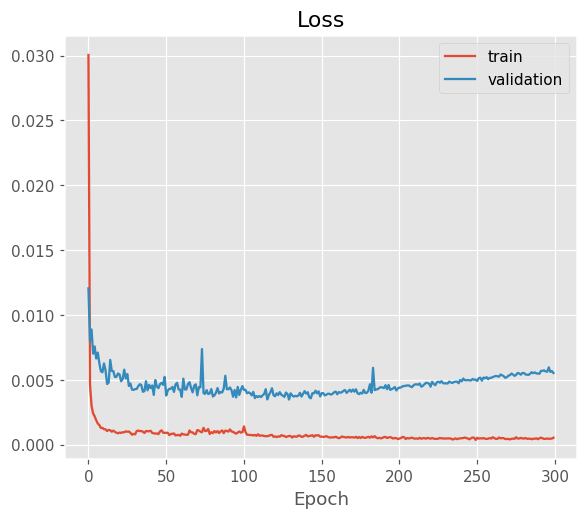

In [278]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(hist.history["loss"], label="train")
ax.plot(hist.history["val_loss"], label="validation")
ax.set_title("Loss")
ax.set_xlabel("Epoch")
ax.legend()

fig.savefig(f"results/localizer_training.png")

In [279]:
def plot(image, true, pred):
    img = image.copy()
    h, w, _ = img.shape
    t = true.copy()
    t_x1, t_y1 = int(t[0]*w), int(t[1]*h)
    t_x2, t_y2 = int((t[0] + t[2])*w), int((t[1] + t[3])*h)
    p = pred.copy()
    p_x1, p_y1 = int(p[0]*w), int(p[1]*h)
    p_x2, p_y2 = int((p[0] + p[2])*w), int((p[1] + p[3])*h)
    cv.rectangle(img, (t_x1, t_y1), (t_x2, t_y2), (0, 255, 0), 3)
    cv.rectangle(img, (p_x1, p_y1), (p_x2, p_y2), (0, 0, 255), 3)
    return img

A continuación se muestra un ejemplo de las predicciones que está ejecutando el localizador. El cuadro verde corresponde al real y el rojo, a la predicción.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<ipython-input-279-e41479506b86>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_x1, p_y1 = int(p[0]*w), int(p[1]*h)
<ipython-input-279-e41479506b86>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_x2, p_y2 = int((p[0] + p[2])*w), int((p[1] + p[3])*h)


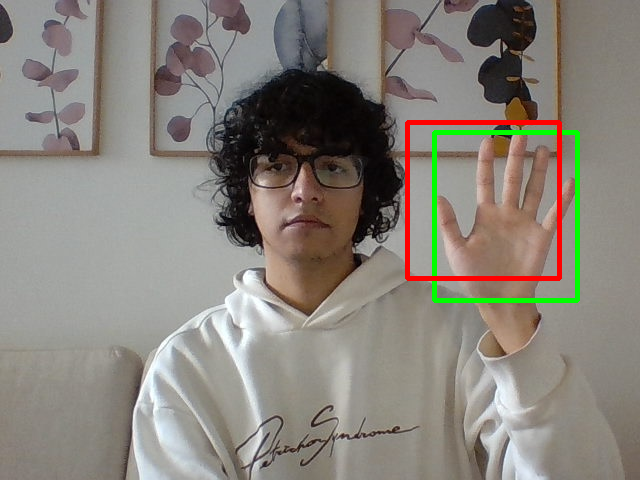

In [280]:
img = plot(X_val[3], y_val[3], localizer.predict(X_val_prep[3:4]).T)
cv_show(img);

## **3. Segmentación**

Ahora se cargan las imágenes que contienen solo los cuadros recortados con las manos para entrenar el modelo de segmentación. Esto se hará para intentar eliminar el fondo del cuadro.

In [333]:
X = []
for label in labels:
    for i in range(16):
        img = cv.imread(f"../data/segmentation/{label}/{label}_{i}.jpg")
        X.append(img)

Aquí el vector objetivo está compuesto por máscaras en las que todos los pixeles dsobre la mano son $1$ y los demás son $0$.

In [334]:
y = []
for label in labels:
    for i in range(16):
        img = cv.imread(f"../data/segmentation/{label}_mask/{label}_{i}.jpg", cv.IMREAD_GRAYSCALE)
        y.append(img)
for i, img in enumerate(y):
    y[i] = np.where(img < 240, 0, 1)

Para este entrenamiento se tienen $80$ imágenes. Cabe anotar que estas son de diferentes tamaño, ya que vienen de recortar las manos en distintas posiciones y señas.

In [335]:
print("Cantidad de imágenes:", len(X))
print("Tamaño de la primera imagen:", X[0].shape)
print("Tamaño de la primera salida:", y[0].shape)

Cantidad de imágenes: 80
Tamaño de la primera imagen: (166, 145, 3)
Tamaño de la primera salida: (166, 145)


In [336]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_val))

64
16


In [337]:
X_train_resized = []
y_train_resized = []
for i in range(len(X_train)):
    X_train_resized.append(tf.image.resize(X_train[i], (128, 128)))
    y_train_resized.append(tf.image.resize(np.expand_dims(y_train[i], axis=-1), (128, 128)))
X_train_resized = np.array(X_train_resized)
y_train_resized = np.array(y_train_resized)

X_val_resized = []
y_val_resized = []
for i in range(len(X_val)):
    X_val_resized.append(tf.image.resize(X_val[i], (128, 128)))
    y_val_resized.append(tf.image.resize(np.expand_dims(y_val[i], axis=-1), (128, 128)))
X_val_resized = np.array(X_val_resized)
y_val_resized = np.array(y_val_resized)

X_train_prep = tf.keras.applications.mobilenet_v2.preprocess_input(X_train_resized)
X_val_prep = tf.keras.applications.mobilenet_v2.preprocess_input(X_val_resized)

train_data = tf.data.Dataset.from_tensor_slices((X_train_prep, y_train_resized)).repeat(50).shuffle(64*50, seed=42).batch(32)
val_data = tf.data.Dataset.from_tensor_slices((X_val_prep, y_val_resized)).repeat(50).shuffle(16*50, seed=42).batch(32)

Ahora se usarán las salidas de capas específicas dentro de la red *MobileNet* como encoder

In [343]:
layer_names = ["block_1_expand_relu",
               "block_3_expand_relu",
               "block_6_expand_relu",
               "block_13_expand_relu",
               "block_16_project"]
extractor_outputs = [extractor.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=extractor.input, outputs=extractor_outputs)

Para el decoder, se usarán los bloques de umsample que ya están implementados en los ejemplos que se encuentran en el repositorio de *TensorFlow*.

In [344]:
up_stack = [pix2pix.upsample(512, 3),
            pix2pix.upsample(256, 3),
            pix2pix.upsample(128, 3),
            pix2pix.upsample(64, 3)]
inputs = tf.keras.layers.Input(shape=(128, 128, 3))
skips = down_stack(inputs)
x = skips[-1]
skips = reversed(skips[:-1])
for up, skip in zip(up_stack, skips):
    x = tf.keras.layers.Concatenate()([up(x), skip])
x = tf.keras.layers.Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding="same")(x)

In [345]:
segmenter = tf.keras.Model(inputs=inputs, outputs=x)
segmenter.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.optimizers.Adam(),
                  metrics=["accuracy"])
segmenter.summary()

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_67       │ [(None, 64, 64,   │  1,841,984 │ input_layer_38[0… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_24       │ (None, 8, 8, 512) │  1,476,608 │ functional_67[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 8, 8,      │          0 │ sequential_24[0]… │
│ (Concatenate)       │ 1088)             │            │ functional_67[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_25       │ (None, 16, 16,    │  2,507,776 │ concatenate_24[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 16, 16,    │          0 │ sequential_25[0]… │
│ (Concatenate)       │ 448)              │            │ functional_67[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_26       │ (None, 32, 32,    │    516,608 │ concatenate_25[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 32, 32,    │          0 │ sequential_26[0]… │
│ (Concatenate)       │ 272)              │            │ functional_67[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_27       │ (None, 64, 64,    │    156,928 │ concatenate_26[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 64, 64,    │          0 │ sequential_27[0]… │
│ (Concatenate)       │ 160)              │            │ functional_67[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_34 │ (None, 128, 128,  │      2,882 │ concatenate_27[0… │
│ (Conv2DTranspose)   │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,502,786 (24.81 MB)

 Trainable params: 4,658,882 (17.77 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

En este caso también se incluyen un *early stopping* y un *checkpoint* para controlar la ejecución y guardar el mejor modelo según la función de pérdida en el conjunto de validación.

In [346]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f"results/segmenter.keras",
                                                verbose=1,
                                                save_best_only=True)
stopping = tf.keras.callbacks.EarlyStopping(patience=20,
                                            verbose=1,
                                            restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                                 patience=15,
                                                 verbose=1,
                                                 min_lr=3e-6)
hist = segmenter.fit(train_data,
                     epochs=100,
                     callbacks=[checkpoint, stopping, reduce_lr],
                     validation_data=val_data)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8579 - loss: 0.2928
Epoch 1: val_loss improved from inf to 0.16195, saving model to results/segmenter.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8586 - loss: 0.2913 - val_accuracy: 0.9249 - val_loss: 0.1619 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9596 - loss: 0.0270
Epoch 2: val_loss improved from 0.16195 to 0.14788, saving model to results/segmenter.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9596 - loss: 0.0269 - val_accuracy: 0.9307 - val_loss: 0.1479 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9618 - loss: 0.0143
Epoch 3: val_loss did not improve from 0.14788
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9618 - loss: 0.0143 - val_accuracy: 0.9298 - val_loss: 0.1676 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9635 - loss: 0

Nótese que el mejor modelo se alcanzó bastante rápido (en la segunda época).

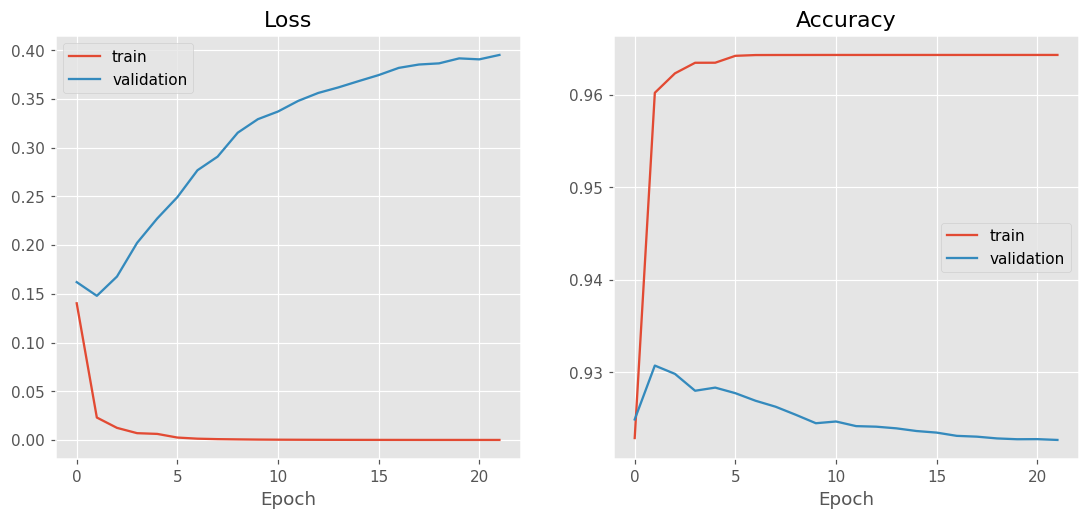

In [347]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

ax0.plot(hist.history["loss"], label="train")
ax0.plot(hist.history["val_loss"], label="validation")
ax0.set_title("Loss")
ax0.set_xlabel("Epoch")
ax0.legend()

ax1.plot(hist.history["accuracy"], label="train")
ax1.plot(hist.history["val_accuracy"], label="validation")
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

fig.savefig(f"results/segmenter_training.png")

In [392]:
def plot(display_list):
    titles = ["Input image", "True mask", "Predicted mask"]
    fig, axes = plt.subplots(ncols=3, figsize=(18, 5))
    for i in range(3):
        axes[i].imshow(display_list[i])
        axes[i].set_title(titles[i])
        axes[i].axis("off")

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

Esta sección de la arquitectura obtuvo un buen desempeño.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


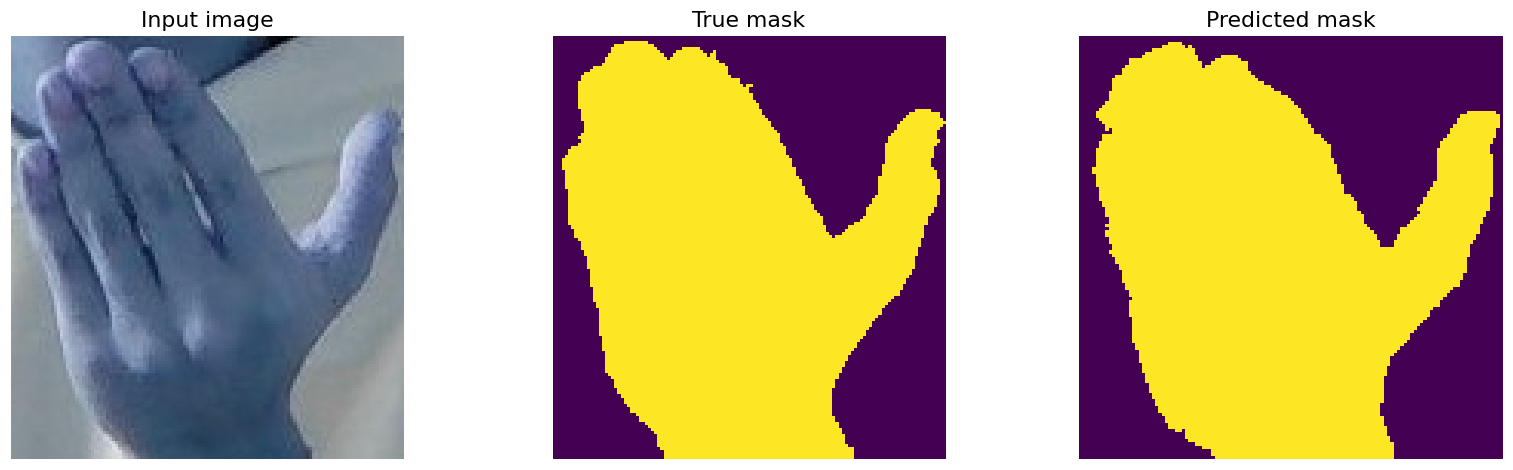

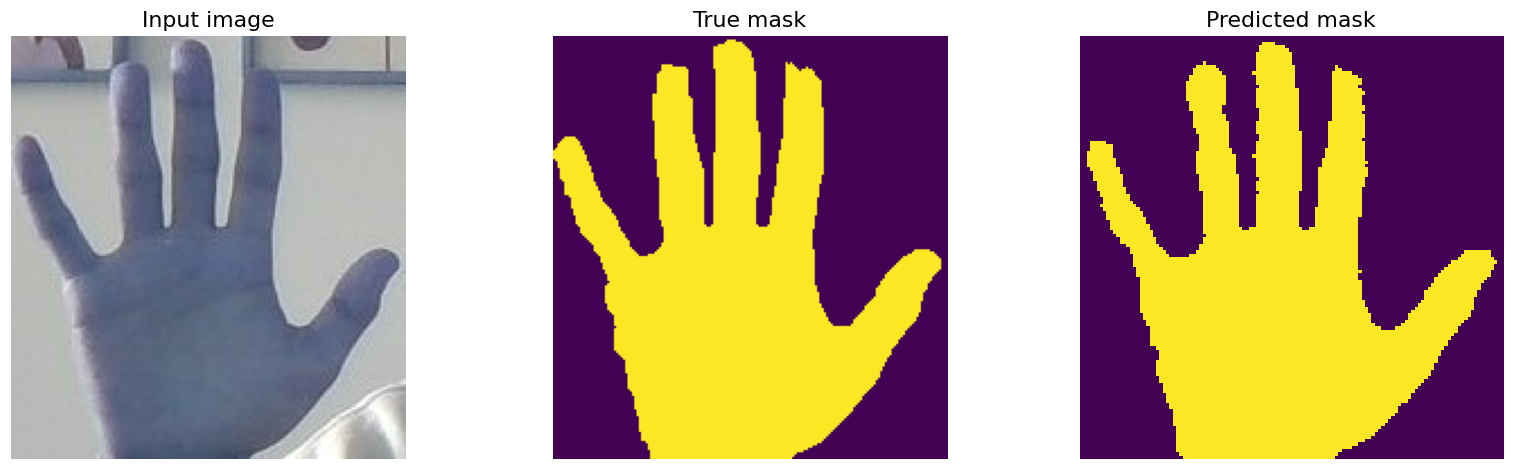

In [393]:
plot([X_val[5], y_val[5][..., tf.newaxis], create_mask(segmenter.predict(X_val_prep[5:6]))])
plot([X_val[6], y_val[6][..., tf.newaxis], create_mask(segmenter.predict(X_val_prep[6:7]))])

## **4. Clasificación**

Finalmente, se buscará clasificar las señas por medio de los cuadros de manos recortados y sin fondo.

In [433]:
for i, img in enumerate(X):
    temp = np.expand_dims(y[i], axis=-1)
    X[i] = np.where(temp == 1, img, 0)

In [441]:
y = []
for i in range(5):
    y.extend([i]*16)
y = np.array(y)

Algunos ejemplos del tipo de datos que recibirá esta última red.

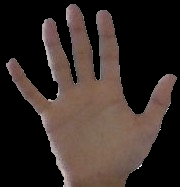

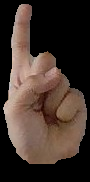

In [439]:
cv_show(X[3])
cv_show(X[42])

In [449]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
print(len(X_train))
print(len(X_val))

64
16


In [450]:
X_train_resized = []
for i in range(len(X_train)):
    X_train_resized.append(tf.image.resize(X_train[i], (128, 128)))
X_train_resized = np.array(X_train_resized)

X_val_resized = []
for i in range(len(X_val)):
    X_val_resized.append(tf.image.resize(X_val[i], (128, 128)))
X_val_resized = np.array(X_val_resized)

X_train_prep = tf.keras.applications.mobilenet_v2.preprocess_input(X_train_resized)
X_val_prep = tf.keras.applications.mobilenet_v2.preprocess_input(X_val_resized)

train_data = tf.data.Dataset.from_tensor_slices((X_train_prep, y_train)).repeat(50).shuffle(64*50, seed=42).batch(32)
val_data = tf.data.Dataset.from_tensor_slices((X_val_prep, y_val)).repeat(50).shuffle(16*50, seed=42).batch(32)

De nuevo, se usará la red *MobileNet* para extraer las características de la mano, las cuales pasarán a través de unas capas densas y una Dropout. La diferencia con la primera es la salida, que en este caso contiene cinco neuronas y una función de activación *softmax* para retornar un vector de probabilidaddes sobre las clases.

In [454]:
dense1 = tf.keras.layers.Dense(units=128, activation="relu")(extractor.output)
drop = tf.keras.layers.Dropout(0.3)(dense1)
dense2 = tf.keras.layers.Dense(units=64, activation="relu")(drop)
softmax_layer = tf.keras.layers.Dense(units=5, activation="softmax", name="softmax_out")(dense2)

In [455]:
classifier = tf.keras.models.Model(inputs=extractor.input, outputs=softmax_layer)
classifier.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                   optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                   metrics=["accuracy"])
classifier.summary()

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,430,533 (9.27 MB)

 Trainable params: 172,549 (674.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [456]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f"results/classifier.keras",
                                                verbose=1,
                                                save_best_only=True)
stopping = tf.keras.callbacks.EarlyStopping(patience=20,
                                            verbose=1,
                                            restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                                 patience=15,
                                                 verbose=1,
                                                 min_lr=3e-6)
hist = classifier.fit(train_data,
                      epochs=100,
                      callbacks=[checkpoint, stopping, reduce_lr],
                      validation_data=val_data)

Epoch 1/100
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8974 - loss: 0.3156
Epoch 1: val_loss improved from inf to 0.01412, saving model to results/classifier.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8997 - loss: 0.3088 - val_accuracy: 1.0000 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 2/100
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8566e-04
Epoch 2: val_loss did not improve from 0.01412
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 8.8208e-04 - val_accuracy: 1.0000 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 3/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9457e-04
Epoch 3: val_loss improved from 0.01412 to 0.00767, saving model to results/classifier.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.9283e-04 - val_accuracy: 1.0000 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 4/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.

El accuracy del modelo llegó a un valor máximo prácticamente al inicio del entrenamiento.

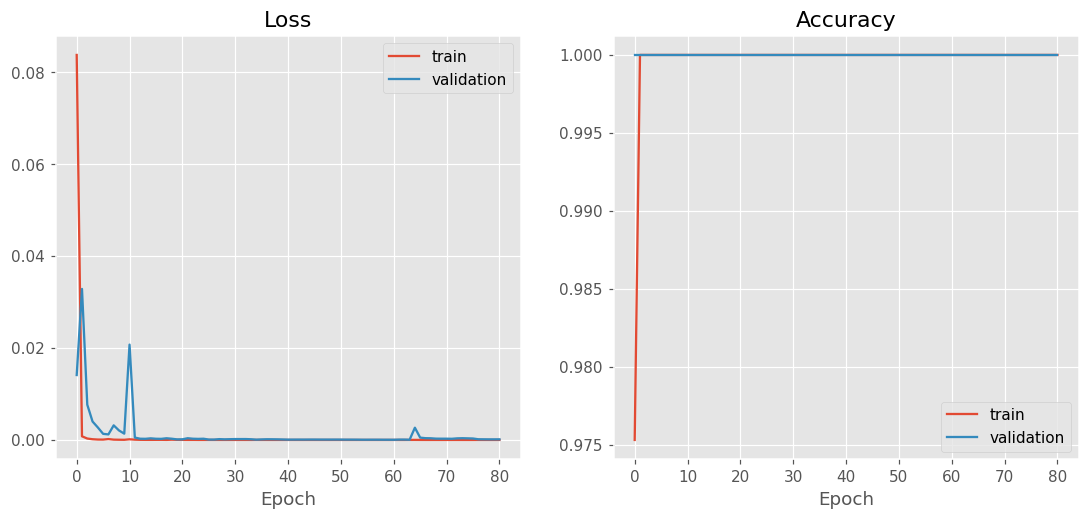

In [457]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

ax0.plot(hist.history["loss"], label="train")
ax0.plot(hist.history["val_loss"], label="validation")
ax0.set_title("Loss")
ax0.set_xlabel("Epoch")
ax0.legend()

ax1.plot(hist.history["accuracy"], label="train")
ax1.plot(hist.history["val_accuracy"], label="validation")
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

fig.savefig(f"results/classifier_training.png")

---
# **Evaluación de desempeño**

## **1. Pipeline de ejecución**

Por último, se presenta un *pipeline* que ejecuta todo el proceso de inferencia sobre una imagen individual, mientras dibuja el cuadro del localizador y escribe la seña predicha sobre la imagen.

In [555]:
def pipeline(image):
    labels = ["Adios", "Gracias", "No", "Por favor", "Si"]
    h, w, _ = image.shape
    loc = tf.keras.models.load_model("results/localizer.keras")
    seg = tf.keras.models.load_model("results/segmenter.keras")
    clf = tf.keras.models.load_model("results/classifier.keras")

    # Localization
    img1 = tf.image.resize(image, (128, 128))
    img1_prep = tf.keras.applications.mobilenet_v2.preprocess_input(img1[tf.newaxis, ...])
    p1 = loc.predict(img1_prep)[0]
    x1, y1 = int(p1[0]*w), int(p1[1]*h)
    x2, y2 = int((p1[0] + p1[2])*w), int((p1[1] + p1[3])*h)
    cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)

    # Segmentation
    image2 = image[x1:x2, y1:y2, :]
    img2 = tf.image.resize(image2, (128, 128))
    img2_prep = tf.keras.applications.mobilenet_v2.preprocess_input(img2[tf.newaxis, ...])
    p2 = seg.predict(img2_prep)[0]
    p2 = tf.math.argmax(p2, axis=-1)
    p2 = np.expand_dims(p2, axis=-1)

    # Classification
    img3 = np.where(p2 == 1, img2, 0)
    img3_prep = tf.keras.applications.mobilenet_v2.preprocess_input(img3[tf.newaxis, ...])
    p3 = np.argmax(clf.predict(img3_prep))
    cv.putText(image, labels[p3], (50, 100), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 6, cv.LINE_AA)
    return image

Ahora se muestran algunos ejemplos de uso del *pipeline* anterior.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


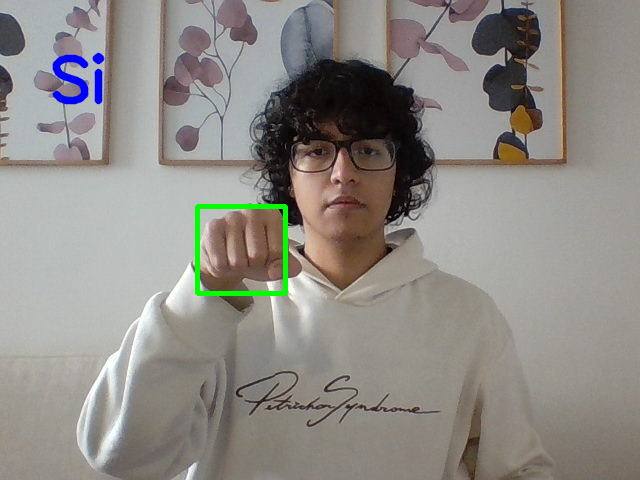

In [556]:
image = cv.imread("../data/localization/si/si_0.jpg")
cv_show(pipeline(image.copy()))

Este es un ejemplo en donde el modelo no predice bien la seña.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


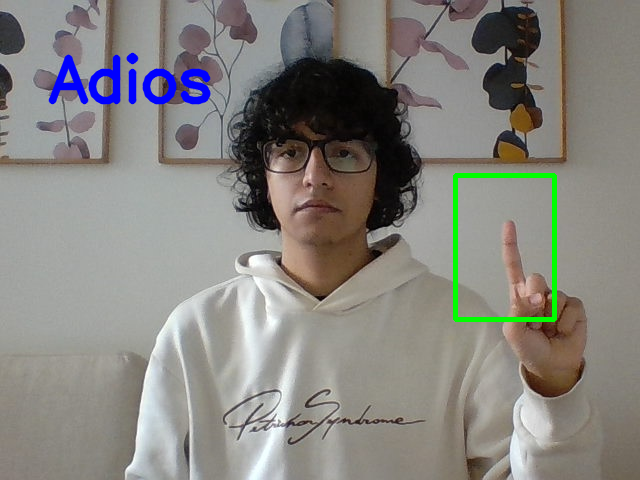

In [559]:
image = cv.imread("../data/localization/no/no_1.jpg")
cv_show(pipeline(image.copy()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


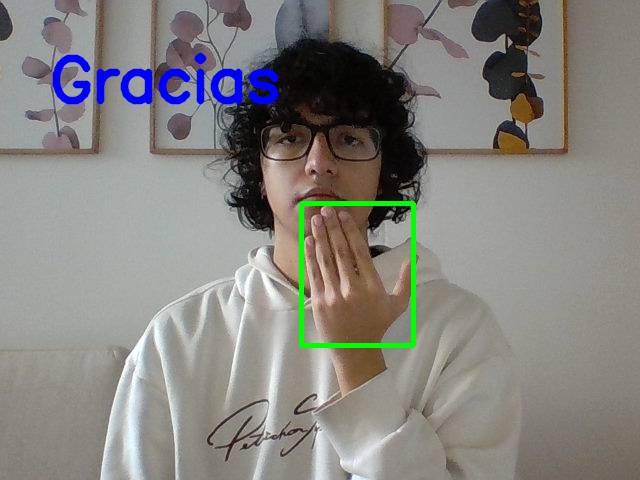

In [557]:
image = cv.imread("../data/localization/gracias/gracias_0.jpg")
cv_show(pipeline(image.copy()))

Este modelo se podría usarse con video capturado desde la cámara. El problema es que la inferencia de la arquitectura es lenta, por lo que no se ve tan bien.

In [ ]:
cap = cv.VideoCapture(0)
time_limit = time.time() + 60
while time.time() < time_limit:
    ret, frame = cap.read()
    result = pipeline(frame.copy())
    cv_show(result)
    cv.waitKey(1)
cap.release()
cv.destroyAllWindows()

## **2. Análisis de resultados**

La conjunción de los tres modelos obtuvo un rendimiento relativamente satisfactorio al clasificar las señas seleccionadas. Al final se evidenció que el modelo aún comete errores con algunas señas específicas, pero puede deberse a la primera parte de la arquitectura, correspondiente a la localización de la mano.

Otro aspecto importante es el tiempo de inferencia durante el *pipeline*, ya que cada imagen se demora 9 segundos en procesarse. En este caso, el tiempo de ejecución podría reducirse un poco limitando la arquitectura a la localización y clasificación (detección) sin pasar por un proceso de segmentación de las manos.

---
# **Referencias**

- [Diccionario Básico de la Lengua de Señas Colombiana](https://www.colombiaaprende.edu.co/sites/default/files/files_public/2022-04/Diccionario-lengua-de-senas.pdf)
- [Object Localization with Tensorflow](https://github.com/aliosmankaya/ObjectLocalizationWithTensorflow)
- [TensorFlow Examples](https://github.com/tensorflow/examples)
- [TensorFlow - Image segmentation](https://www.tensorflow.org/tutorials/images/segmentation)
- [tf.keras.applications.MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)

---
# **Créditos**

- Samuel David Moreno Vahos